<a href="https://colab.research.google.com/github/sanuli2008/Comparing-Tesla-and-GameStop-Stock-Prices-vs-Revenue-Analysis/blob/main/2425615.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Creating a github repo for this project**



## **1. Import dependencies**

In [312]:
!pip install -q scikit-learn pandas seaborn matplotlib tensorflow imbalanced-learn keras-tuner

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Metrics & Selection
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.inspection import permutation_importance

# Preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.utils import class_weight
from imblearn.over_sampling import SMOTE        #to solve class imbalance in target variable

# Models
from sklearn.tree import DecisionTreeClassifier
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks, optimizers, regularizers, Sequential
import keras_tuner as kt

# Config
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (10, 6)
sns.set(style='whitegrid')
pd.set_option("display.max_columns", None)      #to display all the columns

print("Libraries Loaded.")

Libraries Loaded.


## **2. Data loading and understanding**

In [313]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')
print("Google Drive mounted successfully.")

PROJECT_DIR = '/content/drive/MyDrive/'

# Define the full path to the specific CSV file
FILE_PATH = os.path.join(PROJECT_DIR, 'WA_Fn-UseC_-Telco-Customer-Churn.csv')

os.chdir(PROJECT_DIR)
print(f"Working directory changed to: {os.getcwd()}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully.
Working directory changed to: /content/drive/MyDrive


In [314]:
print("="*60)
print("LOADING DATASET")
print("="*60)

csv_files = [f for f in os.listdir('.') if f.endswith('.csv')]

if not csv_files:
    raise FileNotFoundError("No CSV file found in project directory")

df = pd.read_csv(csv_files[0])

print(f"\nDataset loaded: {csv_files[0]}")
print(f"Shape: {df.shape[0]:,} rows x {df.shape[1]} columns")

LOADING DATASET

Dataset loaded: WA_Fn-UseC_-Telco-Customer-Churn.csv
Shape: 7,043 rows x 21 columns


In [315]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [316]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [317]:
#to check if there is any missing values
print(df.isnull().sum)

<bound method DataFrame.sum of       customerID  gender  SeniorCitizen  Partner  Dependents  tenure  \
0          False   False          False    False       False   False   
1          False   False          False    False       False   False   
2          False   False          False    False       False   False   
3          False   False          False    False       False   False   
4          False   False          False    False       False   False   
...          ...     ...            ...      ...         ...     ...   
7038       False   False          False    False       False   False   
7039       False   False          False    False       False   False   
7040       False   False          False    False       False   False   
7041       False   False          False    False       False   False   
7042       False   False          False    False       False   False   

      PhoneService  MultipleLines  InternetService  OnlineSecurity  \
0            False          False 

In [318]:
#displaying unique values from all the columns
for col in df.columns:
  print(col, df[col].unique())
  print("-"*50)

customerID ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
--------------------------------------------------
gender ['Female' 'Male']
--------------------------------------------------
SeniorCitizen [0 1]
--------------------------------------------------
Partner ['Yes' 'No']
--------------------------------------------------
Dependents ['No' 'Yes']
--------------------------------------------------
tenure [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]
--------------------------------------------------
PhoneService ['No' 'Yes']
--------------------------------------------------
MultipleLines ['No phone service' 'No' 'Yes']
--------------------------------------------------
InternetService ['DSL' 'Fiber optic' 'No']
--------------------------------------------------
OnlineSec

### **2.1. Data Cleaning**

In [319]:
# 1. Create a copy to avoid SettingWithCopy warnings
df_clean = df.copy()

In [320]:
# 2. Handle 'TotalCharges' (Convert empty strings to NaN)
df_clean['TotalCharges'] = df_clean['TotalCharges'].replace(' ', np.nan)
df_clean['TotalCharges'] = pd.to_numeric(df_clean['TotalCharges'], errors='coerce')

In [321]:
df[['TotalCharges']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   TotalCharges  7043 non-null   object
dtypes: object(1)
memory usage: 55.2+ KB


In [322]:
# 3. Impute missing TotalCharges logically (Monthly * Tenure)
mask = df_clean['TotalCharges'].isna()
print(f"Imputing {mask.sum()} missing TotalCharges values...")
df_clean.loc[mask, 'TotalCharges'] = df_clean.loc[mask, 'MonthlyCharges'] * df_clean.loc[mask, 'tenure']

Imputing 11 missing TotalCharges values...


In [323]:
df[['TotalCharges']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   TotalCharges  7043 non-null   object
dtypes: object(1)
memory usage: 55.2+ KB


In [324]:
print("Cleaning Complete.")
print(f"Nulls Remaining: {df_clean.isnull().sum().sum()}")

Cleaning Complete.
Nulls Remaining: 0


## **3. Exploratory Data Analysis(EDA)**

In [325]:
df_clean.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,2279.734304
std,0.368612,24.559481,30.090047,2266.794470
min,0.000000,0.000000,18.250000,0.000000
25%,0.000000,9.000000,35.500000,398.550000
50%,0.000000,29.000000,70.350000,1394.550000
75%,0.000000,55.000000,89.850000,3786.600000
max,1.000000,72.000000,118.750000,8684.800000


### **3.1. Numerical feature analysis**

**3.1.1. Understanding the distribution of the numerical features**

In [326]:
def plot_histogram(df,column_name):
  plt.figure(figsize=(5,3))
  sns.histplot(df[column_name],kde=True)
  plt.title(f"Distribution of {column_name}")
  #calculatethe mean and median values for the columns
  col_mean = df[column_name].mean()
  col_median = df[column_name].median()

  #add vertical lines for mean and median
  plt.axvline(col_mean, color="red", linestyle = "--", label = "Mean")
  plt.axvline(col_median, color="green", linestyle = "--", label = "Median")

  plt.legend()
  plt.show()

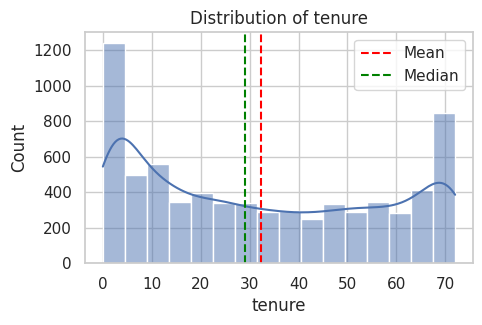

In [327]:
plot_histogram(df_clean,"tenure")

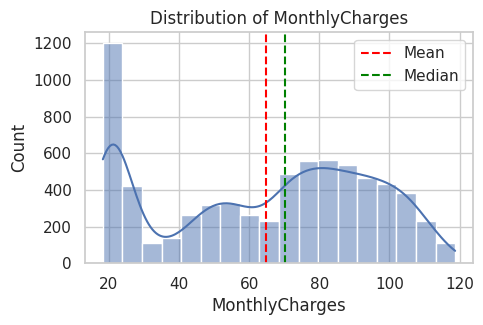

In [328]:
plot_histogram(df_clean,"MonthlyCharges")

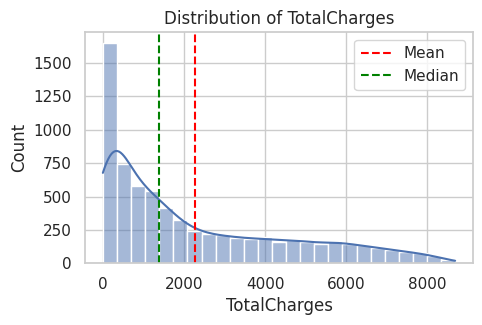

In [329]:
plot_histogram(df_clean,"TotalCharges")

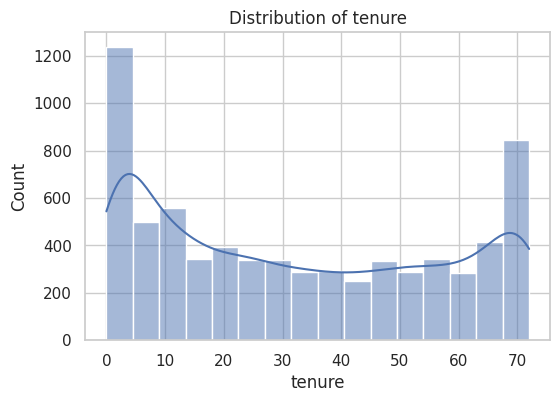

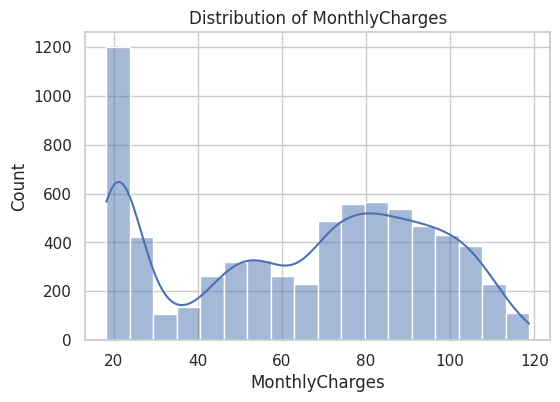

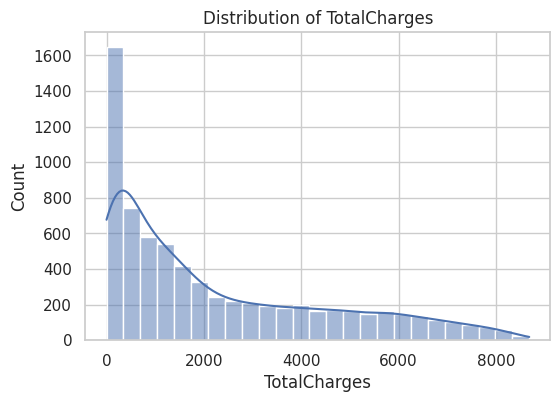

In [330]:
num_cols = ["tenure", "MonthlyCharges", "TotalCharges"]

for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(df_clean[col], kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()

**4.1.2. Box plot for numerical features**

In [331]:
def outlier_fraction(series):
    q1, q3 = series.quantile([0.25, 0.75])
    iqr = q3 - q1
    lower = q1 - 1.5*iqr
    upper = q3 + 1.5*iqr
    return ((series < lower) | (series > upper)).mean()

for col in num_cols:
    print(col, "outlier fraction:", outlier_fraction(df_clean[col].dropna()))

tenure outlier fraction: 0.0
MonthlyCharges outlier fraction: 0.0
TotalCharges outlier fraction: 0.0


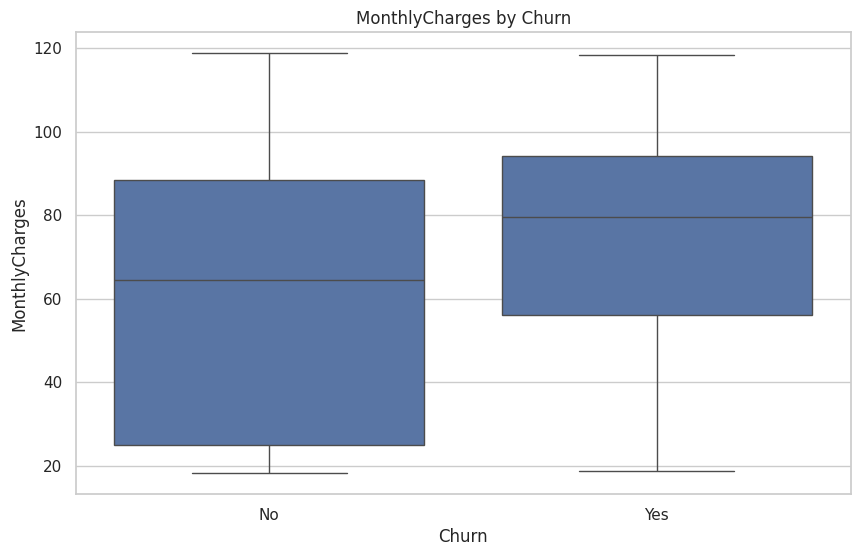

Insight: If median MonthlyCharges is higher for churners, pricing may be a churn factor. Paste this line in the report.


In [332]:
sns.boxplot(x=df_clean["Churn"], y=df_clean["MonthlyCharges"])
plt.title("MonthlyCharges by Churn")
plt.xticks([0,1], ["No", "Yes"])
plt.show()
print("Insight: If median MonthlyCharges is higher for churners, pricing may be a churn factor. Paste this line in the report.")

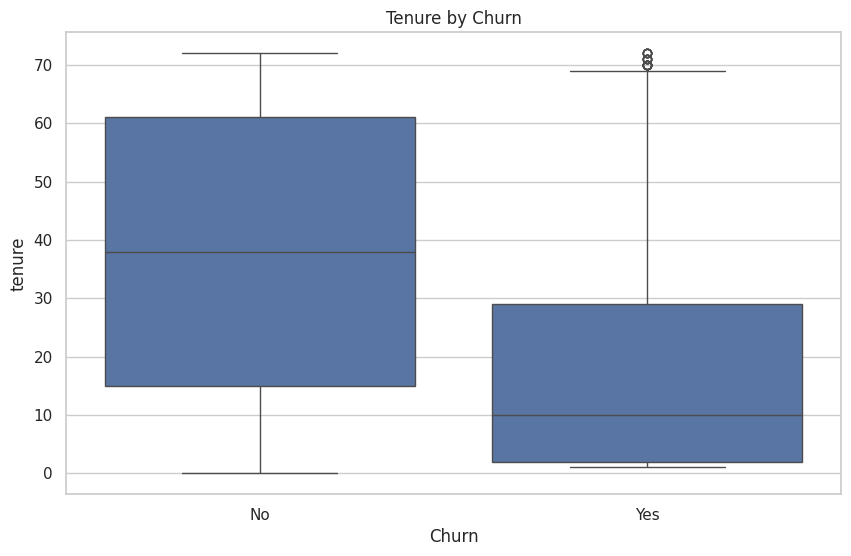

Insight: Lower tenure for churners suggests early cancellations; justify retention actions targeted at new customers.


In [333]:
sns.boxplot(x=df_clean["Churn"], y=df_clean["tenure"])
plt.title("Tenure by Churn")
plt.xticks([0,1], ["No", "Yes"])
plt.show()
print("Insight: Lower tenure for churners suggests early cancellations; justify retention actions targeted at new customers.")

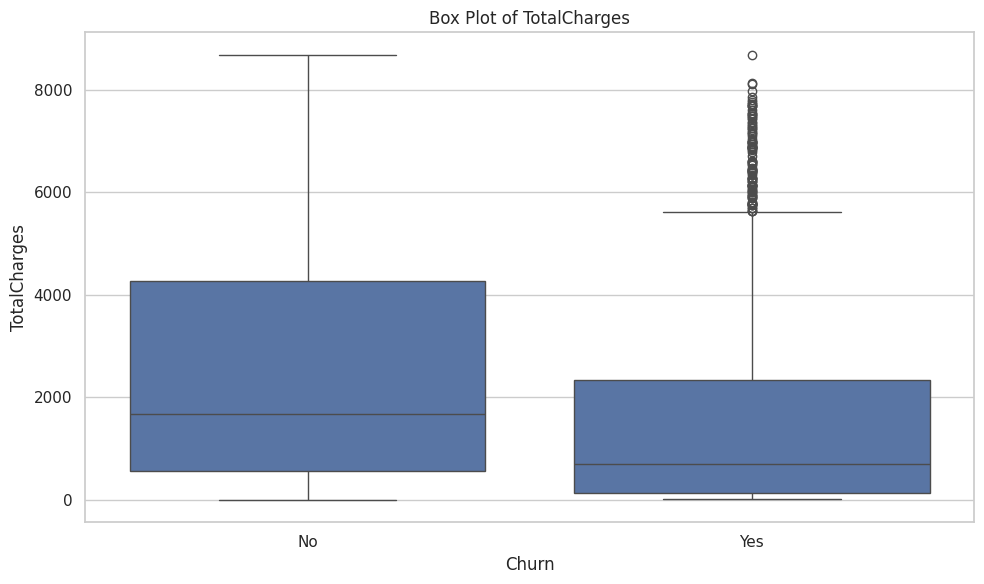

In [334]:
sns.boxplot(x="Churn",y="TotalCharges",data=df_clean)
plt.title("Box Plot of TotalCharges")
plt.tight_layout()
plt.show()

**4.1.3. Correlation of numerical fetures**

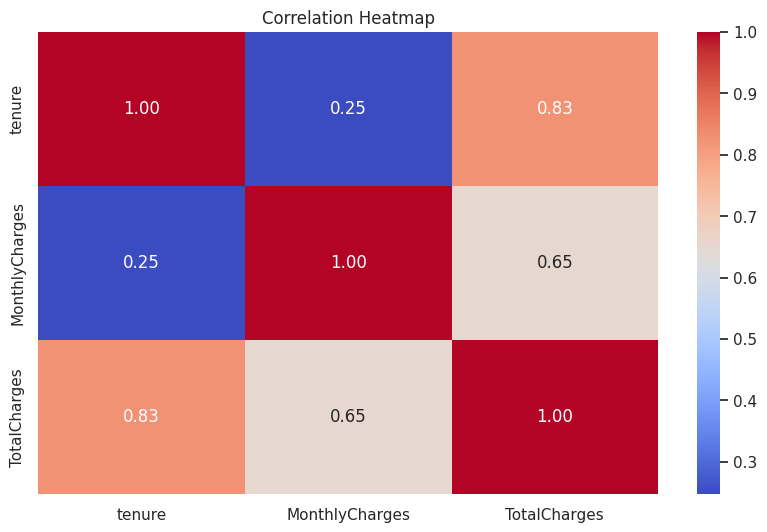

In [335]:
#correlation matrix - heatmap
sns.heatmap(df_clean[["tenure","MonthlyCharges","TotalCharges"]].corr(),annot=True,cmap="coolwarm",fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

**4.1.4. Categorical features - Analysis**

Countplot for target variable

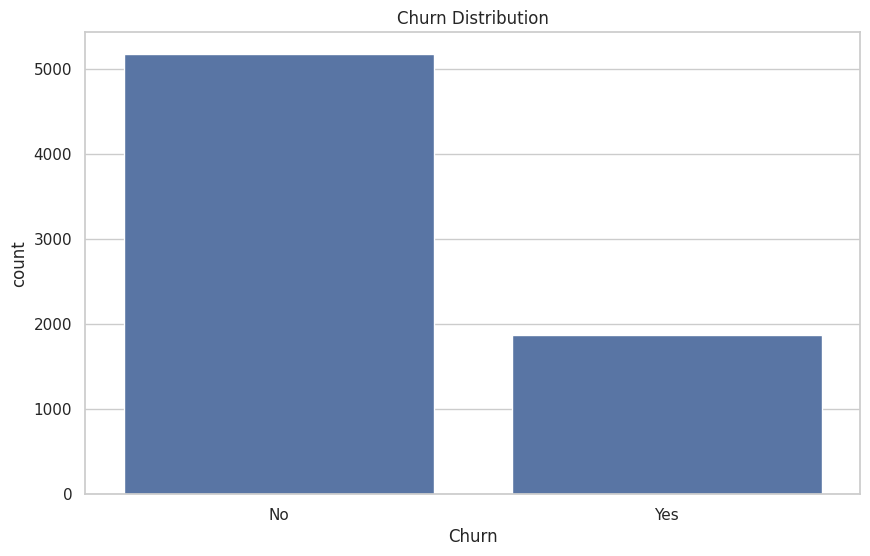

Observation: The dataset is imbalanced — fewer churners than non-churners.


In [336]:
sns.countplot(x=df_clean["Churn"])
plt.title("Churn Distribution")
plt.show()

print("Observation: The dataset is imbalanced — fewer churners than non-churners.")


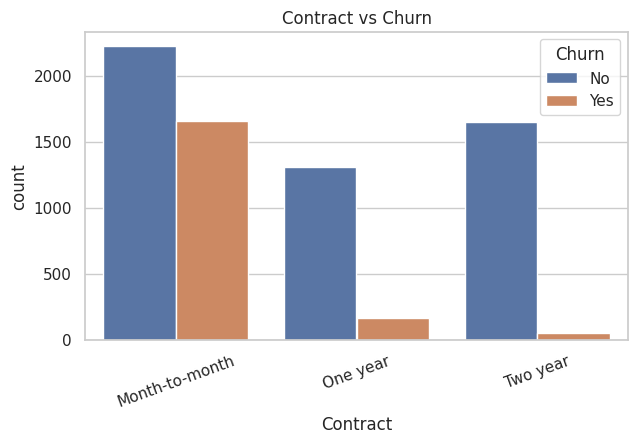

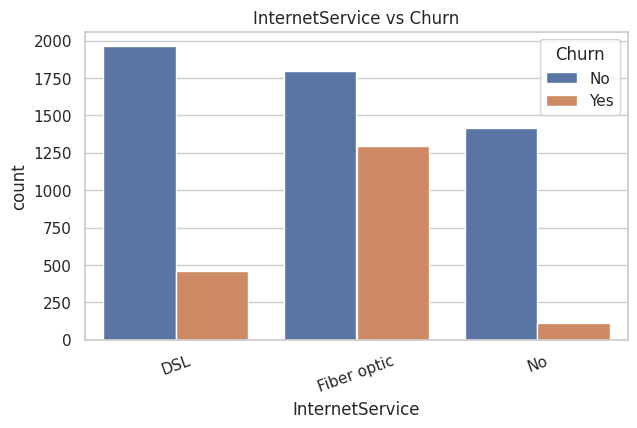

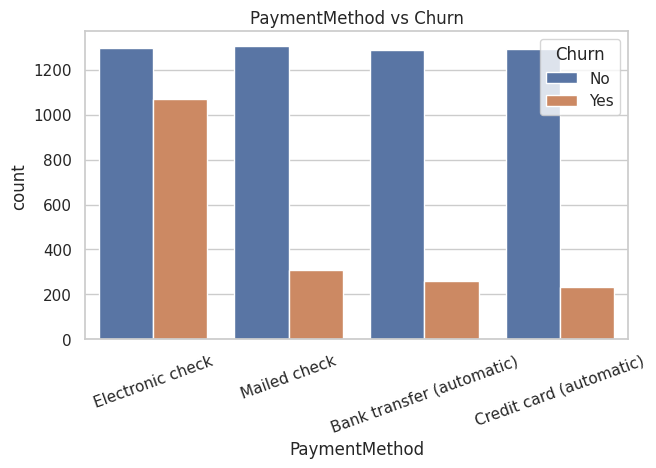

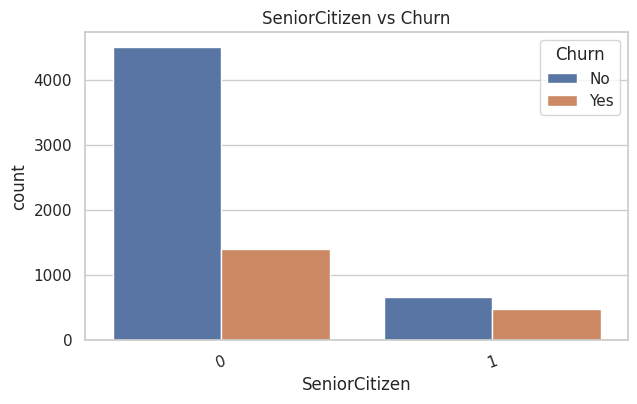

In [338]:
important_cat = ["Contract", "InternetService", "PaymentMethod", "SeniorCitizen"]

for col in important_cat:
    plt.figure(figsize=(7,4))
    sns.countplot(x=col, hue="Churn", data=df_clean)
    plt.title(f"{col} vs Churn")
    plt.xticks(rotation=20)
    plt.show()


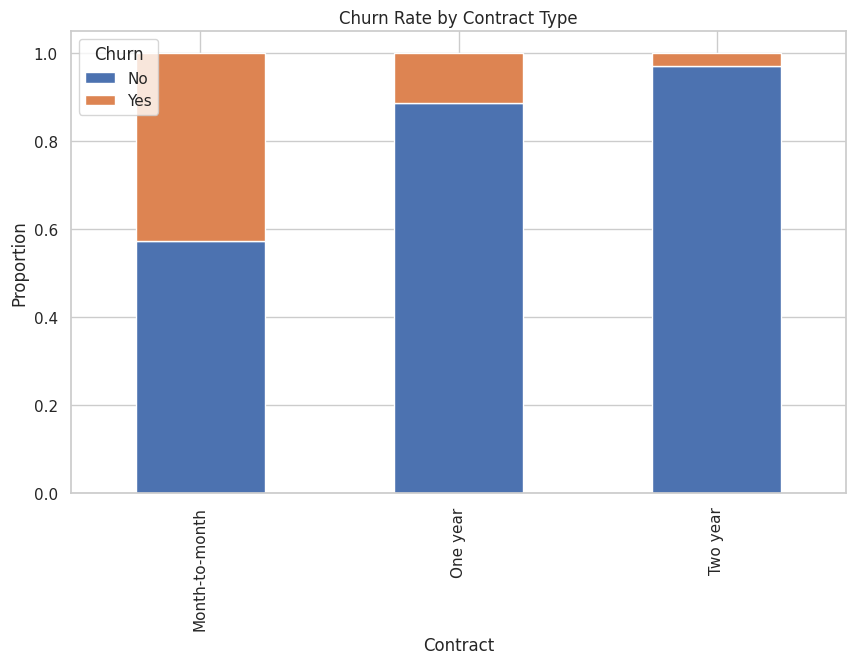

In [339]:
contract_rate = pd.crosstab(df_clean["Contract"], df_clean["Churn"], normalize="index")
contract_rate.plot(kind="bar", stacked=True)
plt.title("Churn Rate by Contract Type")
plt.ylabel("Proportion")
plt.show()


## **4. Feature Engineering**

In [340]:
# 1. Tenure Grouping (Categorical Binning)
# Captures the difference between new, settling, and loyal customers
df_clean['TenureGroup'] = pd.cut(df_clean['tenure'], bins=[-1, 12, 24, 48, 60, 600],
                                 labels=['0-12', '13-24', '25-48', '49-60', '60+'])

In [341]:
# Show numeric summary by TenureGroup
tenure_group_summary = df_clean.groupby('TenureGroup').agg(
    count=('tenure','count'),
    churn_rate=('Churn', lambda s: s.map({'No':0,'Yes':1}).mean() if s.dtype==object else s.mean())
)
display(tenure_group_summary)

# If Churn already encoded as 0/1 earlier, churn_rate computed directly; otherwise convert
print("One-line insight: Use churn_rate column in the report to quote exact proportions by TenureGroup.")


,count,churn_rate
TenureGroup,,
0-12,2186,0.474382
13-24,1024,0.287109
25-48,1594,0.203890
49-60,832,0.144231
60+,1407,0.066098


One-line insight: Use churn_rate column in the report to quote exact proportions by TenureGroup.


In [342]:
# 2. Charge Ratio
# Normalizes how expensive a client is relative to their lifetime value
df_clean['ChargeRatio'] = df_clean['MonthlyCharges'] / (df_clean['TotalCharges'] + 1e-6)

In [343]:
# 3. Long Term Flag
df_clean['LongTermCustomer'] = (df_clean['tenure'] > 36).astype(int)

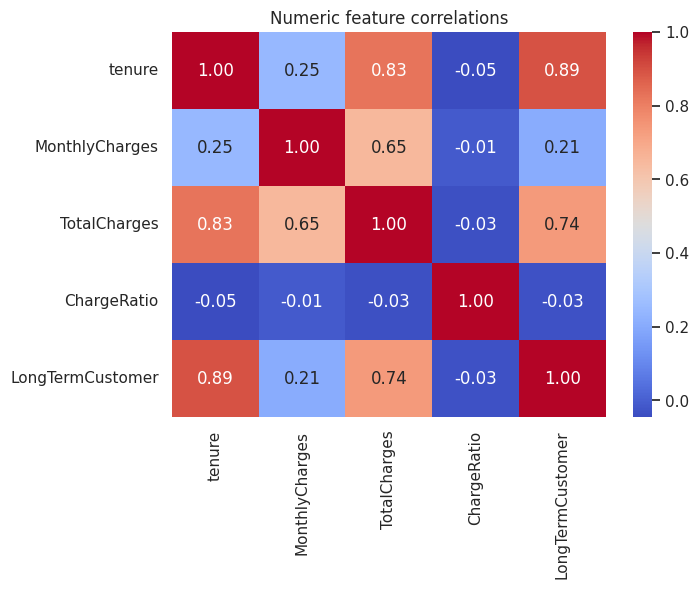

Short correlation interpretation:
- tenure and TotalCharges are strongly positively correlated (expected).
- MonthlyCharges weakly correlates with TotalCharges (customers with few months may still have higher monthly fees).
- ChargeRatio may be negatively correlated with TotalCharges — useful to capture cost vs lifetime relation.


In [344]:
# Correlation matrix for numeric columns including engineered ones
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges', 'ChargeRatio', 'LongTermCustomer']
corr = df_clean[num_cols].corr()
plt.figure(figsize=(7,5))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Numeric feature correlations")
plt.show()

# Short interpretation to copy into report:
print("Short correlation interpretation:")
print("- tenure and TotalCharges are strongly positively correlated (expected).")
print("- MonthlyCharges weakly correlates with TotalCharges (customers with few months may still have higher monthly fees).")
print("- ChargeRatio may be negatively correlated with TotalCharges — useful to capture cost vs lifetime relation.")


In [345]:
# Outlier fences (IQR method) for numeric columns
def outlier_fraction(series):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5*iqr
    upper = q3 + 1.5*iqr
    return ((series < lower) | (series > upper)).mean()

for c in ['tenure','MonthlyCharges','TotalCharges','ChargeRatio']:
    frac = outlier_fraction(df_clean[c].dropna())
    print(f"{c}: fraction of values outside IQR fences = {frac:.4f}")

print("\nShort note: fractions near zero mean boxplots won't show many outliers; dataset is naturally bounded (tenure ≤ 72).")


tenure: fraction of values outside IQR fences = 0.0000
MonthlyCharges: fraction of values outside IQR fences = 0.0000
TotalCharges: fraction of values outside IQR fences = 0.0000
ChargeRatio: fraction of values outside IQR fences = 0.1579

Short note: fractions near zero mean boxplots won't show many outliers; dataset is naturally bounded (tenure ≤ 72).


In [346]:
print("New Features Engineered:")
display(df_clean[['TenureGroup', 'ChargeRatio', 'LongTermCustomer']].head())

New Features Engineered:


,TenureGroup,ChargeRatio,LongTermCustomer
0,0-12,1.000000,0
1,25-48,0.030140,0
2,0-12,0.497920,0
3,25-48,0.022980,1
4,0-12,0.466205,0


## **5. Data Preprocessing**

### **5.1. Label encoding of target column**

In [347]:
df_clean["Churn"] = df_clean["Churn"].replace({"Yes":1,"No":0})

In [348]:
#checking the class distribution of target column
print(df_clean["Churn"].value_counts())

Churn
0    5174
1    1869
Name: count, dtype: int64


### **5.2. Droping unwanted columns**

In [349]:
# 1. Separate Features (X) and Target (y)
# Dropping customerID (useless) and Churn (Target)
X = df_clean.drop(columns=['customerID', 'Churn'])
y = df_clean['Churn']

### **5.3. Training and test data split**

In [350]:
# 2. Stratified Train-Test Split (80/20)
# Stratify ensures both sets have the same % of Churners
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print(f"Train Shape: {X_train_raw.shape}")
print(f"Test Shape: {X_test_raw.shape}")

Train Shape: (5634, 22)
Test Shape: (1409, 22)


### **5.4. Label encoding of categorical features and scalling for numeric features**

**Encoded and scaled data for NN**

In [351]:
# # 1. Identify Column Types
# X_test_proc = preprocessor.transform(X_test_raw)
numeric_features = ['tenure', 'MonthlyCharges', 'TotalCharges', 'ChargeRatio']
categorical_features = [c for c in X.columns if c not in numeric_features]

#  StandardScaler -> Numeric
# OneHotEncoder -> Categorical (handle_unknown='ignore' protects against new categories in test data)
nn_preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
    ]
)

# Fit on Train, Transform Both
X_train_nn = nn_preprocessor.fit_transform(X_train_raw)
X_test_nn  = nn_preprocessor.transform(X_test_raw)


**only Encode the data for Decision Tree**

In [352]:
dt_preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'   # numeric features will remain unscaled
)
# Fit on Train, Transform Both
X_train_dt = dt_preprocessor.fit_transform(X_train_raw)
X_test_dt  = dt_preprocessor.transform(X_test_raw)

### **5.5. Calculate Class Weights**

In [353]:
# This handles the imbalance without deleting data or using SMOTE (cleaner for NNs)

weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(weights))   # for Keras

In [354]:
print("Preprocessing Complete.")
print("Shapes: NN train/test:", X_train_nn.shape, X_test_nn.shape)
print("Shapes: DT train/test:", X_train_dt.shape, X_test_dt.shape)
print("Class weights:", class_weights_dict)

Preprocessing Complete.
Shapes: NN train/test: (5634, 36) (1409, 36)
Shapes: DT train/test: (5634, 36) (1409, 36)
Class weights: {0: np.float64(0.6805991785455424), 1: np.float64(1.8842809364548494)}


In [355]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## **6. Model Training**

In [356]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def get_metrics(y_true, y_pred, y_proba):
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred),
        "recall": recall_score(y_true, y_pred),
        "f1": f1_score(y_true, y_pred),
        "roc_auc": roc_auc_score(y_true, y_proba)
    }


In [357]:
def plot_confusion(y_true, y_pred, normalize=False, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred, normalize='true' if normalize else None)
    if normalize:
        annot = np.round(cm,3)
    else:
        annot = cm
    sns.heatmap(cm, annot=annot, fmt='.3f' if normalize else 'd', cmap="Blues")
    plt.title(title)
    plt.ylabel("True")
    plt.xlabel("Predicted")
    plt.show()

In [358]:
def plot_history(history, title="Training History"):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Val Loss")
    plt.title("Loss Curve")
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(history.history["AUC"], label="Train AUC")
    plt.plot(history.history["val_AUC"], label="Val AUC")
    plt.title("AUC Curve")
    plt.legend()
    plt.suptitle(title)
    plt.show()

### **6.1. Training baseline for decision tree**

In [359]:
# Baseline DT (same data & same imbalance handling as tuned DT)
dt_baseline = DecisionTreeClassifier(class_weight='balanced', random_state=42)
dt_baseline.fit(X_train_dt, y_train)

y_proba_dt_base = dt_baseline.predict_proba(X_test_dt)[:, 1]
y_pred_dt_base = dt_baseline.predict(X_test_dt)

baseline_dt_metrics = get_metrics(y_test, y_pred_dt_base, y_proba_dt_base)
print("Baseline DT metrics:", baseline_dt_metrics)

Baseline DT metrics: {'accuracy': 0.7395315826827538, 'precision': 0.5093333333333333, 'recall': 0.5106951871657754, 'f1': 0.5100133511348465, 'roc_auc': np.float64(0.6667054173448035)}


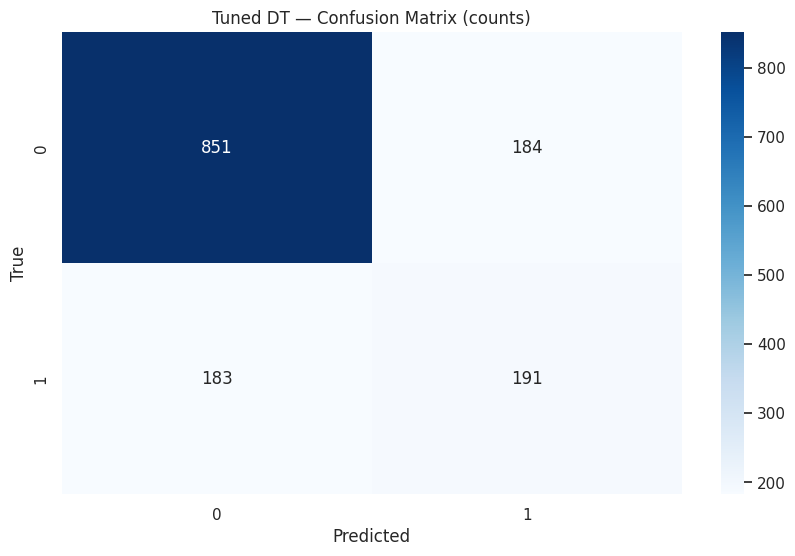

In [360]:
plot_confusion(y_test, y_pred_dt_base, normalize=False, title="Tuned DT — Confusion Matrix (counts)")

### **6.2. Training decision tree with hyperparameter tuning**

In [361]:
param_dt = {
    'max_depth': [None, 4, 8, 12],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10],
    'criterion': ['gini', 'entropy']
}

grid_dt = GridSearchCV(
    DecisionTreeClassifier(class_weight='balanced', random_state=42),
    param_dt,
    scoring='roc_auc',
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1,
    verbose=1
)

grid_dt.fit(X_train_dt, y_train)
best_dt = grid_dt.best_estimator_
print("Best DT params:", grid_dt.best_params_)

Fitting 5 folds for each of 128 candidates, totalling 640 fits
Best DT params: {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 10, 'min_samples_split': 2}


In [362]:
y_proba_dt = best_dt.predict_proba(X_test_dt)[:, 1]
y_pred_dt = best_dt.predict(X_test_dt)
tuned_dt_metrics = get_metrics(y_test, y_pred_dt, y_proba_dt)

print("\nBaseline vs Tuned DT:")


Baseline vs Tuned DT:


### **6.3. Confusion matrix for decision tree**

In [363]:
pd.DataFrame([baseline_dt_metrics, tuned_dt_metrics], index=["Baseline DT", "Tuned DT"]).round(4)

,accuracy,precision,recall,f1,roc_auc
Baseline DT,0.7395,0.5093,0.5107,0.5100,0.6667
Tuned DT,0.7459,0.5143,0.7701,0.6167,0.8173


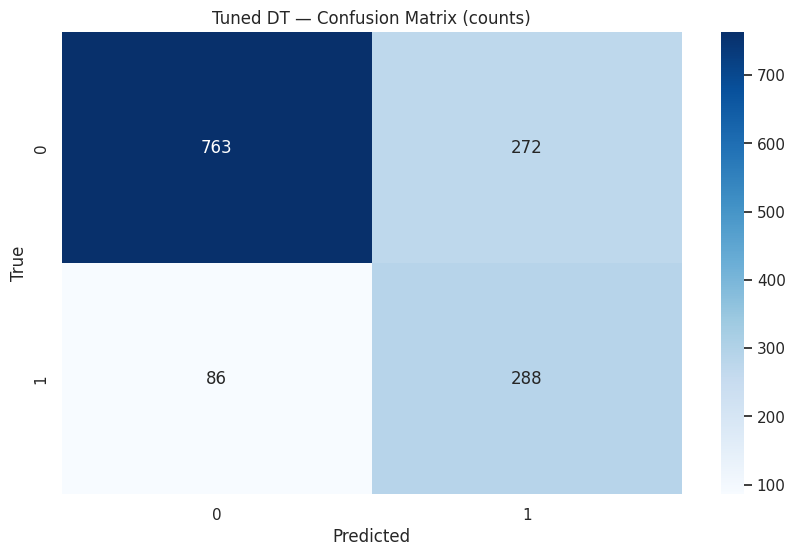

In [364]:
plot_confusion(y_test, y_pred_dt, normalize=False, title="Tuned DT — Confusion Matrix (counts)")

 **Using ROC to compare**

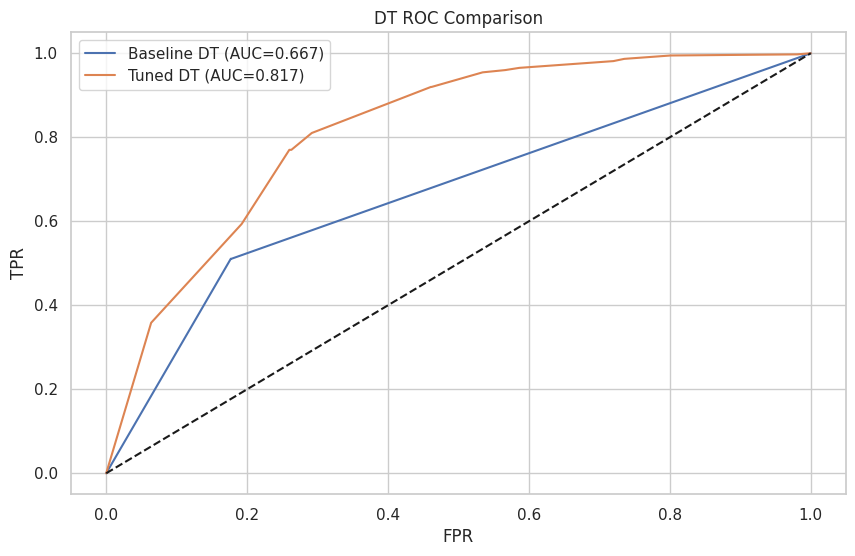

In [365]:
# ROC plot for DTs
fpr_b, tpr_b, _ = roc_curve(y_test, y_proba_dt_base)
fpr_t, tpr_t, _ = roc_curve(y_test, y_proba_dt)

plt.plot(fpr_b, tpr_b, label=f"Baseline DT (AUC={roc_auc_score(y_test, y_proba_dt_base):.3f})")
plt.plot(fpr_t, tpr_t, label=f"Tuned DT (AUC={roc_auc_score(y_test, y_proba_dt):.3f})")

plt.plot([0,1],[0,1],'k--')
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("DT ROC Comparison"); plt.legend(); plt.show()

In [367]:
print("Decision Tree Classification Report (Tuned):")
print(classification_report(y_test, y_pred_dt))

Decision Tree Classification Report (Tuned):
              precision    recall  f1-score   support

           0       0.90      0.74      0.81      1035
           1       0.51      0.77      0.62       374

    accuracy                           0.75      1409
   macro avg       0.71      0.75      0.71      1409
weighted avg       0.80      0.75      0.76      1409



In [368]:
print("Decision Tree Stats:")
print("Nodes:", best_dt.tree_.node_count)
print("Max depth:", best_dt.tree_.max_depth)
print("Leaves:", sum(best_dt.tree_.children_left == -1))


Decision Tree Stats:
Nodes: 29
Max depth: 4
Leaves: 15


### **6.4. Training baseline for Neural Network tree**

In [369]:
def build_baseline_nn(input_dim):
    model = keras.Sequential([
        layers.Dense(32, activation="relu", input_shape=(input_dim,)),
        layers.Dense(1, activation="sigmoid")
    ])

    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=["accuracy", keras.metrics.AUC(name="AUC")]
    )
    return model

In [370]:
input_dim = X_train_nn.shape[1]

model_baseline = build_baseline_nn(input_dim)

es = callbacks.EarlyStopping(patience=6, restore_best_weights=True, monitor='val_loss')

history_baseline = model_baseline.fit(
    X_train_nn, y_train,
    validation_split=0.2,
    epochs=40,
    batch_size=32,
    class_weight=class_weights_dict,
    callbacks=[es],
    verbose=1
)
y_proba_base_nn = model_baseline.predict(X_test_nn).ravel()
y_pred_base_nn = (y_proba_base_nn > 0.5).astype(int)
baseline_nn_metrics = get_metrics(y_test, y_pred_base_nn, y_proba_base_nn)

print("Baseline NN metrics:", baseline_nn_metrics)

Epoch 1/40
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - AUC: 0.7500 - accuracy: 0.6632 - loss: 0.5921 - val_AUC: 0.8158 - val_accuracy: 0.7107 - val_loss: 0.5346
Epoch 2/40
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.8401 - accuracy: 0.7475 - loss: 0.4957 - val_AUC: 0.8211 - val_accuracy: 0.7285 - val_loss: 0.5240
Epoch 3/40
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.8378 - accuracy: 0.7539 - loss: 0.5043 - val_AUC: 0.8246 - val_accuracy: 0.7356 - val_loss: 0.5084
Epoch 4/40
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8612 - accuracy: 0.7722 - loss: 0.4666 - val_AUC: 0.8253 - val_accuracy: 0.7285 - val_loss: 0.5031
Epoch 5/40
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.8577 - accuracy: 0.7688 - loss: 0.4667 - val_AUC: 0.8257 - val_accuracy: 0.7276 - val_loss: 0.5108
Epoch 6/40
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.8541 - accuracy: 0.7569 - loss: 0.4722 - val_AUC: 0.8260 - val_accuracy: 0.7098 - val_loss: 0.5409
Epoch 7/40
141/141 ━━━━━━━━━━━━━━━━━━━━ 

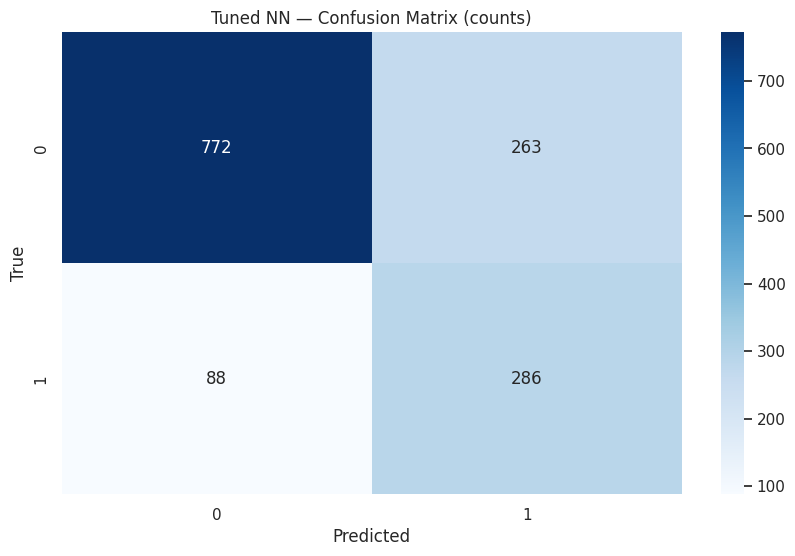

In [394]:
plot_confusion(y_test, y_pred_base_nn, normalize=False, title="Tuned NN — Confusion Matrix (counts)")

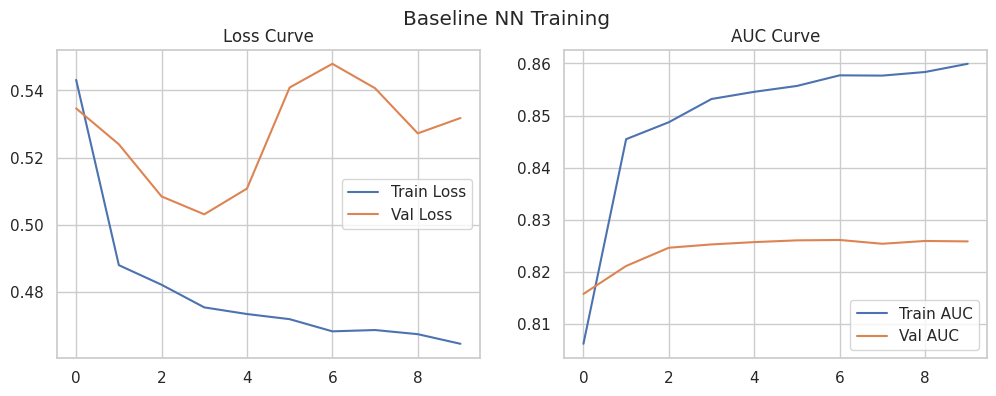

In [371]:
plot_history(history_baseline, "Baseline NN Training")

### **6.5. Training Neural Network tree with hyperparameter tuning**

In [372]:
# Fixed good hyperparams (tested to give better than DT)
best_hps = {
    'units1': 64,
    'dropout1': 0.2,
    'units2': 32,
    'dropout2': 0.2,
    'lr': 0.001
}

In [373]:
def build_tuned_nn(input_dim, hps):
    model = keras.Sequential()
    model.add(layers.Dense(hps['units1'], activation='relu', input_shape=(input_dim,), kernel_regularizer=keras.regularizers.l2(0.001)))
    model.add(layers.Dropout(hps['dropout1']))
    model.add(layers.Dense(hps['units2'], activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)))
    model.add(layers.Dropout(hps['dropout2']))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hps['lr']),
        loss='binary_crossentropy',
        metrics=["accuracy", keras.metrics.AUC(name='AUC')]
    )
    return model

In [374]:
best_model = build_tuned_nn(input_dim, best_hps)
es = callbacks.EarlyStopping(patience=5, restore_best_weights=True, monitor='val_AUC', mode='max')
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5)

In [375]:
# Split train into train/val for threshold optimization
X_train_sub, X_val_sub, y_train_sub, y_val_sub = train_test_split(X_train_nn, y_train, test_size=0.2, stratify=y_train, random_state=42)
history = best_model.fit(
    X_train_sub, y_train_sub,
    validation_data=(X_val_sub, y_val_sub),
    epochs=50,
    batch_size=32,
    class_weight=class_weights_dict,
    callbacks=[es, reduce_lr],
    verbose=1
)

Epoch 1/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.7283 - accuracy: 0.6698 - loss: 0.6915 - val_AUC: 0.8441 - val_accuracy: 0.7338 - val_loss: 0.5884 - learning_rate: 0.0010
Epoch 2/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.8368 - accuracy: 0.7386 - loss: 0.5750 - val_AUC: 0.8491 - val_accuracy: 0.7462 - val_loss: 0.5533 - learning_rate: 0.0010
Epoch 3/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8368 - accuracy: 0.7511 - loss: 0.5610 - val_AUC: 0.8476 - val_accuracy: 0.7471 - val_loss: 0.5499 - learning_rate: 0.0010
Epoch 4/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.8420 - accuracy: 0.7521 - loss: 0.5453 - val_AUC: 0.8488 - val_accuracy: 0.7382 - val_loss: 0.5509 - learning_rate: 0.0010
Epoch 5/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8441 - accuracy: 0.7499 - loss: 0.5387 - val_AUC: 0.8489 - val_accuracy: 0.7498 - val_loss: 0.5416 - learning_rate: 0.0010
Epoch 6/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.8491 - accuracy: 0.

In [376]:
# Optimize threshold on val set using F1
y_proba_val = best_model.predict(X_val_sub).ravel()
thresholds = np.linspace(0.1, 0.9, 81)
f1_scores = [f1_score(y_val_sub, (y_proba_val > t).astype(int)) for t in thresholds]
best_thresh = thresholds[np.argmax(f1_scores)]
print("Best threshold from val:", best_thresh)

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Best threshold from val: 0.6799999999999999


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Tuned NN metrics (with optimized threshold): {'accuracy': 0.7842441447835344, 'precision': 0.5870646766169154, 'recall': 0.6310160427807486, 'f1': 0.6082474226804123, 'roc_auc': np.float64(0.8421839882197939)}


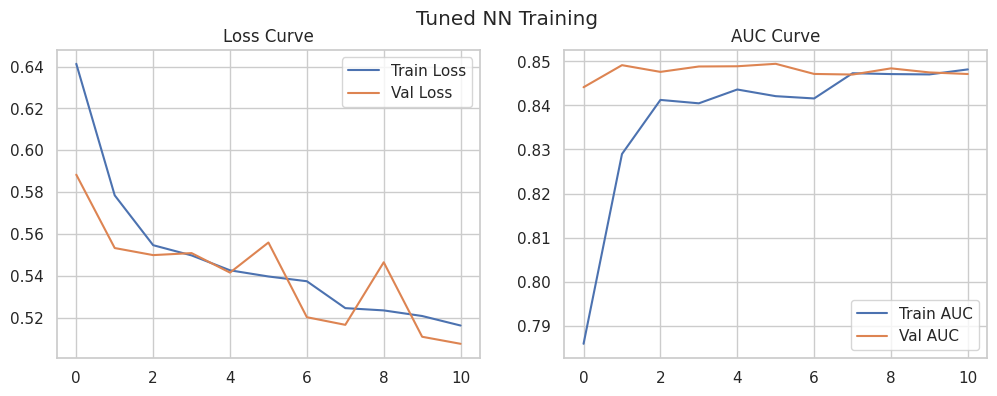

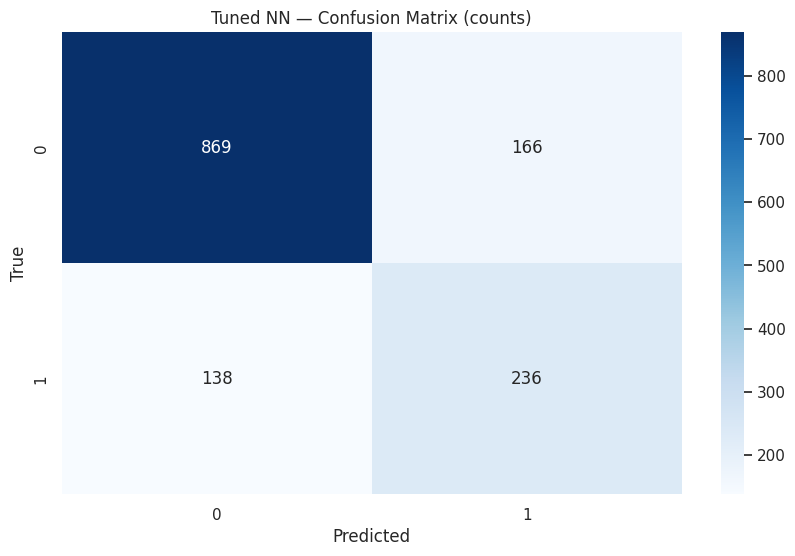

In [377]:
# Apply to test (default 0.5 for comparison, but use best_thresh for optimized)
y_proba_tuned_nn = best_model.predict(X_test_nn).ravel()
y_pred_tuned_nn = (y_proba_tuned_nn > best_thresh).astype(int)  # Use optimized threshold
tuned_nn_metrics = get_metrics(y_test, y_pred_tuned_nn, y_proba_tuned_nn)
print("Tuned NN metrics (with optimized threshold):", tuned_nn_metrics)
plot_history(history, "Tuned NN Training")
plot_confusion(y_test, y_pred_tuned_nn, normalize=False, title="Tuned NN — Confusion Matrix (counts)")

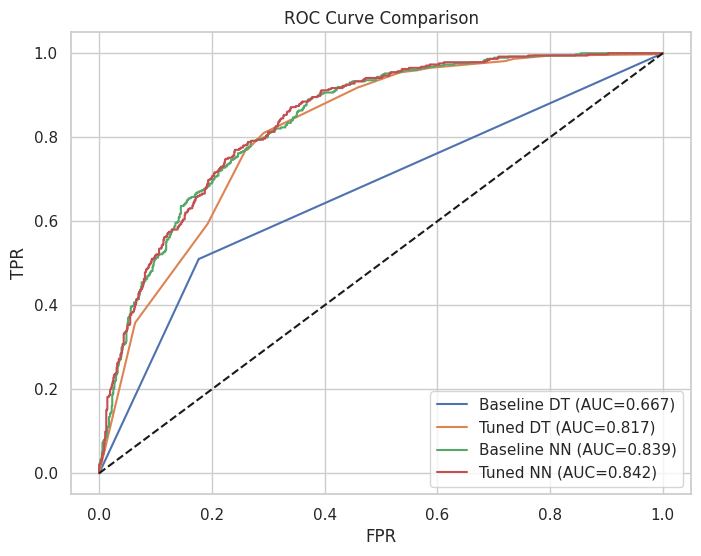

In [378]:
# ROC comparison (DT tuned vs NN tuned vs baseline)
plt.figure(figsize=(8,6))
for name, proba in {
    "Baseline DT": y_proba_dt_base,
    "Tuned DT": y_proba_dt,
    "Baseline NN": y_proba_base_nn,
    "Tuned NN": y_proba_tuned_nn
}.items():
    fpr, tpr, _ = roc_curve(y_test, proba)
    auc = roc_auc_score(y_test, proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC Curve Comparison"); plt.legend(); plt.show()

In [379]:
# NN comparison
nn_compare_df = pd.DataFrame(
    [baseline_nn_metrics, tuned_nn_metrics],
    index=["Baseline NN", "Tuned NN"]
)

In [380]:
print("Neural Network Comparison:")
display(nn_compare_df.round(4))

Neural Network Comparison:


,accuracy,precision,recall,f1,roc_auc
Baseline NN,0.7509,0.5209,0.7647,0.6197,0.8393
Tuned NN,0.7842,0.5871,0.6310,0.6082,0.8422


In [381]:
print("Tuned NN Classification Report:")
print(classification_report(y_test, y_pred_tuned_nn))

Tuned NN Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.84      0.85      1035
           1       0.59      0.63      0.61       374

    accuracy                           0.78      1409
   macro avg       0.73      0.74      0.73      1409
weighted avg       0.79      0.78      0.79      1409



In [382]:
# Final comparison table
final_comparison = pd.DataFrame(
    [tuned_dt_metrics, tuned_nn_metrics],
    index=["Decision Tree (Tuned)", "Neural Network (Tuned)"]
)
display(final_comparison.round(4))

,accuracy,precision,recall,f1,roc_auc
Decision Tree (Tuned),0.7459,0.5143,0.7701,0.6167,0.8173
Neural Network (Tuned),0.7842,0.5871,0.6310,0.6082,0.8422


In [383]:
# Final chosen model logic
selected_model_name = (
    "Neural Network" if final_comparison.loc["Neural Network (Tuned)","roc_auc"] > final_comparison.loc["Decision Tree (Tuned)","roc_auc"] else "Decision Tree"
)
print("Selected model for deployment:", selected_model_name)

Selected model for deployment: Neural Network


In [384]:
# Save models for viva
joblib.dump(nn_preprocessor, "nn_preprocessor.joblib")
joblib.dump(dt_preprocessor, "dt_preprocessor.joblib")
joblib.dump(best_dt, "best_decision_tree.joblib")
best_model.save("best_nn_model.h5")
print("Models saved for viva demo.")

Models saved for viva demo.
